## Overview of the Data
We'll begin by getting a sense of what the data looks like.

In [4]:
!conda install -yc conda-forge ipython-sql

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done


In [5]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

In [19]:

%%sql
-- five first rows
select *
from facts
limit 5;


 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [15]:
%%sql

SELECT *
  FROM sqlite_master
 WHERE type='table';

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


### Some statistics
- Minimum population
- Maximum population
- Minimum population growth
- Maximum population growth

In [21]:
%%sql
select min(population), max(population), min(population_growth), max(population_growth)
from facts;

 * sqlite:///factbook.db
Done.


min(population),max(population),min(population_growth),max(population_growth)
0,7256490011,0.0,4.02


### observations
We see a few interesting things in the summary statistics on the previous screen:

- There's a country with a population of 0
- There's a country with a population of 7256490011 (or more than 7.2 billion people)

#### Let's find the problem in this database

1. query that returns the countries with the maximum population.
2. query that returns the countries with the minimum population.

In [24]:
%%sql
select name, population
from facts
where population = (select max(population)
                   from facts);

 * sqlite:///factbook.db
Done.


name,population
World,7256490011


In [25]:
%%sql
select name, population
from facts
where population = (select min(population)
                   from facts);

 * sqlite:///factbook.db
Done.


name,population
Antarctica,0


### Observations
It seems like the table contains a row for the whole world, which explains the population of over 7.2 billion. It also seems like the table contains a row for Antarctica, which explains the population of 0. This seems to match the CIA Factbook page for Antarctica:
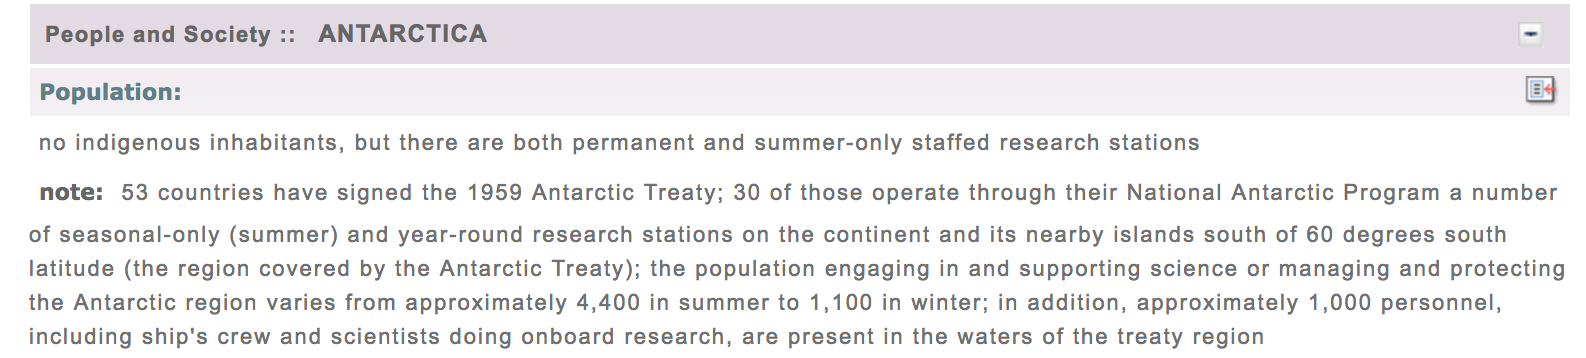

Now that we know this, we should recalculate the summary statistics we calculated earlier — this time excluding the row for the whole world.

### Summary Statistics Revisited

In [30]:
%%sql
select min(population), max(population), min(population_growth), max(population_growth)
from facts
where name <> 'World';

 * sqlite:///factbook.db
Done.


min(population),max(population),min(population_growth),max(population_growth)
0,1367485388,0.0,4.02


In [34]:
%%sql
select round(avg(population), 2) as avg_population, round(avg(area), 2) as avg_area
from facts
where name <> 'World';

 * sqlite:///factbook.db
Done.


avg_population,avg_area
32242666.57,555093.55


### Finding Densely Populated Countries

In [51]:
%%sql
select *
from facts
where population > (select avg(population)
                   from facts
                   where name <> 'World'
                   )
and area < (select avg(area)
            from facts
            where name <> 'World'
            )
order by name;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
14,bg,Bangladesh,148460,130170,18290,168957745,1.6,21.14,5.61,0.46
65,gm,Germany,357022,348672,8350,80854408,0.17,8.47,11.42,1.24
80,iz,Iraq,438317,437367,950,37056169,2.93,31.45,3.77,1.62
83,it,Italy,301340,294140,7200,61855120,0.27,8.74,10.19,4.1
85,ja,Japan,377915,364485,13430,126919659,0.16,7.93,9.51,0.0
91,ks,"Korea, South",99720,96920,2800,49115196,0.14,8.19,6.75,0.0
120,mo,Morocco,446550,446300,250,33322699,1.0,18.2,4.81,3.36
138,rp,Philippines,300000,298170,1830,100998376,1.61,24.27,6.11,2.09
139,pl,Poland,312685,304255,8430,38562189,0.09,9.74,10.19,0.46
163,sp,Spain,505370,498980,6390,48146134,0.89,9.64,9.04,8.31



Some of these countries are generally known to be densely populated, so we have confidence in our results!